<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling_Computer_Vision/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Mount and Packages/Modules Importation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'cuda'

# **※ Dataset Preparation**

###**CIFAR-10 Dataset** -- *32 X 32 pixels RGB Color images* with 10 class labels  
0(비행기), 1(자동차), 2(새), 3(고양이), 4(사슴), 5(개), 6(개구리), 7(말), 8(배), 9(트럭)

Files already downloaded and verified
Files already downloaded and verified
Train Data Length : 50000
# of Class Labels : [0 1 2 3 4 5 6 7 8 9]


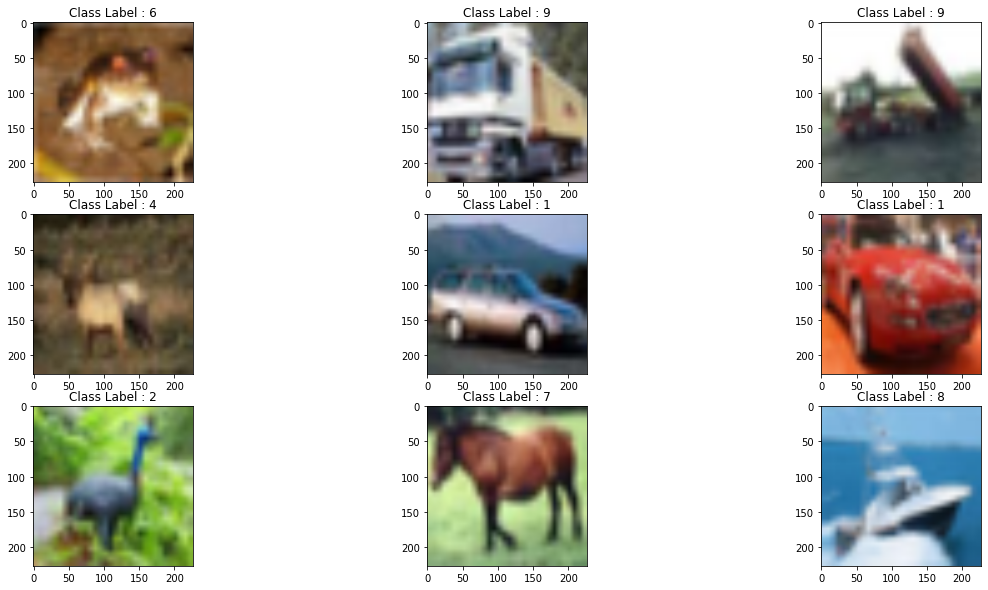

In [ ]:
## Define Dataset Root Path and Transforms
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "data")

apply_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor()
])


## Get CIFAR-10 Image Dataset
train_data = torchvision.datasets.CIFAR10(
    root=root,
    train=True,
    download=True,
    transform=apply_transform
)

test_data = torchvision.datasets.CIFAR10(
    root=root,
    train=False,
    download=True,
    transform=apply_transform
)


## Define Image Plot function
def sample_img_show(data, figsize=(20, 10)):
    fig = plt.figure(figsize=figsize)
    for i in range(9):
        image = data[i][0]
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"Class Label : {data[i][1]}")
    fig.show()


## Check CIFAR-10 Dataset
print(f"Train Data Length : {len(train_data.targets)}")
print(f"# of Class Labels : {np.unique(train_data.targets)}")
sample_img_show(data=train_data)

###**Training / Validation Dataset Split**

In [ ]:
## Training / Validation Dataset Split with random_split
random_seed = 0
torch.manual_seed(random_seed)

valid_size = int(len(train_data) * 0.2)
train_size = len(train_data) - valid_size
train_data, valid_data = random_split(train_data, [train_size, valid_size])

print(f"Training Dataset : {len(train_data)}")
print(f"Validation Dataset : {len(valid_data)}")
print()

print(train_data[0][0].shape)

Training Dataset : 40000
Validation Dataset : 10000

torch.Size([3, 227, 227])


###**Definition of DataLoader Class**

In [ ]:
## Definition of DataLoader Class
train_loader = DataLoader(dataset=train_data, batch_size=50, shuffle=True, drop_last=False)
valid_loader = DataLoader(dataset=valid_data, batch_size=50, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=test_data, batch_size=50, shuffle=False, drop_last=False)

loaders = {}
loaders["train"] = train_loader
loaders["valid"] = valid_loader
loaders["test"] = test_loader

print(f"Train Loader Length = {len(train_loader)},  Valid Loader Length = {len(valid_loader)},  Test Loader Length = {len(test_loader)}")

Train Loader Length = 800,  Valid Loader Length = 200,  Test Loader Length = 200


# <font color="#FF0000"> **※ AlexNet Model and Actuator Definition** </font>

### <font color="#FF0000"> **① Architecture of AlexNet Model with Dual-GPUs** </font>

In [ ]:
## AlexNet Model Definition
class AlexNet(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()

        self.alexnet_conv = nn.Sequential(                                                            # Input Dataste Size = 3 X 227 X 227
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),                      # ① 1st Conv Block : Output size = 96 X 27 X 27
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),          # ② 2nd Conv Block : Output size = 256 X 13 X 13
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),         # ③ 3rd Conv Block : Output size = 384 X 13 X 13
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),         # ④ 4th Conv Block : Output size = 384 X 13 X 13
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),         # ⑤ 5th Conv Block : Output size = 256 X 6 X 6
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.alexnet_fc = nn.Sequential(
            nn.Linear(in_features=256*6*6, out_features=4096),                                        # ⑥ 6th Fully-Connected Layer : Output size = 4096
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=4096),                                           # ⑦ 7th Fully-Connected Layer : Output size = 4096
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=n_class)                                         # ⑧ 8th Fully-Connected Layer : Output size = 10
        )

        # self.init_weight()
    
    # def init_weight(self):
    #   for conv_layer in self.alexnet_conv:
    #     if isinstance(conv_layer, nn.Conv2d):
    #       nn.init.normal_(conv_layer.weight, mean=0, std=0.01)
    #       nn.init.constant_(conv_layer.bias, 0)
        
    #   nn.init.constant_(self.alexnet_conv[4].bias, 1)
    #   nn.init.constant_(self.alexnet_conv[10].bias, 1)
    #   nn.init.constant_(self.alexnet_conv[12].bias, 1)
  
    def forward(self, input):
        temp = self.alexnet_conv(input)
        temp = temp.view(-1, 256*6*6)
        output = self.alexnet_fc(temp)
        
        return output

alexnet_model = AlexNet(n_class=10).to(device)
summary(alexnet_model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

### <font color="#FF0000"> **② Actuator(Trainer/Tester) Construction for AlexNet** </font>

In [ ]:
## AlexNet Actuator Definition
class AlexNet_Actuator(nn.Module):
    def __init__(self, model, loaders, opt="sgd", lr=0.01, has_scheduler=False, device="cuda"):
        super().__init__()

        self.model = model
        self.loss = nn.CrossEntropyLoss()

        self.train_loader = loaders["train"]
        self.valid_loader = loaders["valid"]
        self.test_loader = loaders["test"]

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()
        
        self.device = device
    
    def _get_optimizer(self, opt="sgd", lr=0.01):
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        elif opt == "adagrad":
            self.optimizer = torch.optim.Adagrad(params=self.model.parameters(), lr=lr)
        elif opt == "adadelta":
            self.optimizer = torch.optim.Adadelta(params=self.model.parameters(), lr=lr)
        elif opt == "rmsprop":
            self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"Inputted Optimizer {opt} is not Supported")
    
    def _get_scheduler(self):
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=10, gamma=0.3, verbose=True)    # 학습의 총 epoch에서 step_size마다 gamma의 비율로 learning rate를 순차적으로 줄임
        # self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)   # 학습 도중 lr_lambda에 정의한 function에 의해 learning rate을 순차적으로 줄임
    
    def train_and_valid(self, max_epochs=10, disp_epochs=1):
        print("========== Train and Valid Start ==========")
        start_time = time.time()

        history = {"Train_Loss" : [], "Train_Acc" : [], "Valid_Loss" : [], "Valid_Acc" : []}

        for epoch in range(max_epochs):
            train_loss, train_acc = self._train_epoch()
            valid_loss, valid_acc = self._valid_epoch()

            history["Train_Loss"].append(train_loss)
            history["Train_Acc"].append(train_acc)
            history["Valid_Loss"].append(valid_loss)
            history["Valid_Acc"].append(valid_acc)

            if self.has_scheduler:
                self.scheduler.step()
            
            if epoch % disp_epochs == 0:
                print(f"{epoch+1}/{max_epochs} Epoch ==> Train Loss : {train_loss:>6f}, Train Acc : {train_acc:>6f}, Valid Loss : {valid_loss:>6f}, Valid Acc : {valid_acc:>6f}, Time : {time.time() - start_time:>3f}")
                start_time = time.time()
        
        self.plot_history(history)
    
    def _train_epoch(self):
        train_epoch_loss, train_epoch_acc = 0, 0
        self.model.train()

        for (a, b) in self.train_loader:
            a = a.to(device=self.device)
            b = b.to(device=self.device)

            b_hat = self.model(a)
            loss = self.loss(b_hat, b)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_epoch_loss += loss.to("cpu").item()
            train_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        train_epoch_loss /= len(self.train_loader)
        train_epoch_acc /= len(self.train_loader)

        return train_epoch_loss, train_epoch_acc
    
    def _valid_epoch(self):
        valid_epoch_loss, valid_epoch_acc = 0, 0
        self.model.eval()

        with torch.no_grad():
            for (a, b) in self.valid_loader:
                a = a.to(device=self.device)
                b = b.to(device=self.device)

                b_hat = self.model(a)
                loss = self.loss(b_hat, b)

                valid_epoch_loss += loss.to("cpu").item()
                valid_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        valid_epoch_loss /= len(self.valid_loader)
        valid_epoch_acc /= len(self.valid_loader)

        return valid_epoch_loss, valid_epoch_acc
    
    def plot_history(self, history):
        fig = plt.figure(figsize=(20, 10))

        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history["Train_Loss"], color="red", label="Train Loss")
        ax.plot(history["Valid_Loss"], color="orange", label="Valid Loss")
        ax.set_title("Loss")
        ax.legend()

        ax = fig.add_subplot(1, 2, 2)
        ax.plot(history["Train_Acc"], color="red", label="Train Accuracy")
        ax.plot(history["Valid_Acc"], color="orange", label="Valid Accuracy")
        ax.set_title("Accuracy")
        ax.legend()

        fig.show()
    
    def test(self):
        print("========== Test Start ==========")
        start_time = time.time()

        test_epoch_loss, test_epoch_acc = 0, 0
        self.model.eval()

        with torch.no_grad():
            for (a, b) in self.test_loader:
                a = a.to(device=self.device)
                b = b.to(device=self.device)

                b_hat = self.model(a)
                loss = self.loss(b_hat, b)

                test_epoch_loss += loss.to("cpu").item()
                test_epoch_acc += (b_hat.argmax(1) == b).type(torch.float).to("cpu").mean().item()
        
        test_epoch_loss /= len(self.test_loader)
        test_epoch_acc /= len(self.test_loader)

        print(f"Test loss: {test_epoch_loss:>6f}, Test acc: {test_epoch_acc:>3f}, Test time : {time.time() - start_time:>3f}")

# <font color="#FFBB00"> **※ Training / Validating / Testing** </font>

Adjusting learning rate of group 0 to 1.0000e-02.
========== Train and Validation Start ==========
Adjusting learning rate of group 0 to 1.0000e-02.
1/20 Epoch ==> Train Loss : 2.284206, Train Acc : 0.119075, Valid Loss : 2.091330, Valid Acc : 0.231200, Time : 137.381333
Adjusting learning rate of group 0 to 1.0000e-02.
2/20 Epoch ==> Train Loss : 1.912628, Train Acc : 0.283200, Valid Loss : 1.684331, Valid Acc : 0.378200, Time : 137.648871
Adjusting learning rate of group 0 to 1.0000e-02.
3/20 Epoch ==> Train Loss : 1.539974, Train Acc : 0.431525, Valid Loss : 1.519709, Valid Acc : 0.447400, Time : 137.404368
Adjusting learning rate of group 0 to 1.0000e-02.
4/20 Epoch ==> Train Loss : 1.286085, Train Acc : 0.535700, Valid Loss : 1.132937, Valid Acc : 0.584600, Time : 137.321401
Adjusting learning rate of group 0 to 1.0000e-02.
5/20 Epoch ==> Train Loss : 1.063202, Train Acc : 0.622675, Valid Loss : 0.962215, Valid Acc : 0.661900, Time : 137.258812
Adjusting learning rate of group 0 t

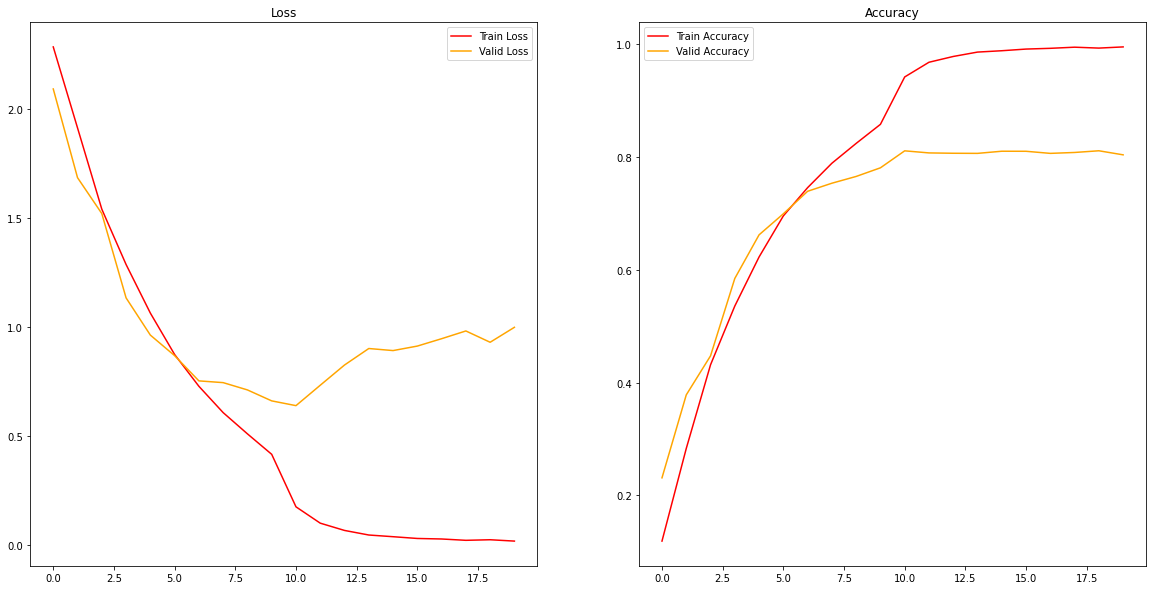

In [ ]:
## Training and Validating and Testing for CIFAR-10 by AlexNet
device = "cuda"
alexnet_model = AlexNet(n_class=10).to(device)
alexnet_actuator = AlexNet_Actuator(model=alexnet_model, loaders=loaders, opt="sgd", lr=0.01, has_scheduler=True, device=device).to(device)

start_time = time.time()
alexnet_actuator.train_and_valid(max_epochs=20, disp_epochs=1)
print(f"Total Training Time : {time.time() - start_time:>3f}")

alexnet_actuator.test()

# <font color="#2F9D27"> **※ AlexNet Model Save and Load** </font>

### <font color="#2F9D27"> **① AlexNet Model Save based on Train/Valid History** </font>

In [ ]:
## AlexNet Model Save
for param_tensor in alexnet_model.state_dict():
    print(f"{param_tensor} : \t {alexnet_model.state_dict()[param_tensor].size()}")   # AlexNet model의 state dictionary 출력 -> 각 layer에서의 parameter들

model_dir = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "AI Algorithm Modeling", "model")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(alexnet_model.state_dict(), os.path.join(model_dir, "AlexNet.pth"))

alexnet_conv.0.weight : 	 torch.Size([96, 3, 11, 11])
alexnet_conv.0.bias : 	 torch.Size([96])
alexnet_conv.4.weight : 	 torch.Size([256, 96, 5, 5])
alexnet_conv.4.bias : 	 torch.Size([256])
alexnet_conv.8.weight : 	 torch.Size([384, 256, 3, 3])
alexnet_conv.8.bias : 	 torch.Size([384])
alexnet_conv.10.weight : 	 torch.Size([384, 384, 3, 3])
alexnet_conv.10.bias : 	 torch.Size([384])
alexnet_conv.12.weight : 	 torch.Size([256, 384, 3, 3])
alexnet_conv.12.bias : 	 torch.Size([256])
alexnet_fc.0.weight : 	 torch.Size([4096, 9216])
alexnet_fc.0.bias : 	 torch.Size([4096])
alexnet_fc.3.weight : 	 torch.Size([4096, 4096])
alexnet_fc.3.bias : 	 torch.Size([4096])
alexnet_fc.6.weight : 	 torch.Size([10, 4096])
alexnet_fc.6.bias : 	 torch.Size([10])


### <font color="#2F9D27"> **② AlexNet Model Load and Performance Estimation** </font>


In [ ]:
## AlexNet Model Load
device = "cuda"

print("========== AlexNet Test without Load ==========")    # ① 먼저 학습하지 않은 상태로 CNN Trainer를 통해 Test dataset 성능 측정
alexnet = AlexNet(n_class=10).to(device)
alexnet_actuator = AlexNet_Actuator(model=alexnet, loaders=loaders, opt="sgd", lr=0.01, has_scheduler=True, device=device).to(device)
alexnet_actuator.test()

model_path = os.path.join(model_dir, "AlexNet.pth")
print(model_path)
print()

print("========== AlexNet Test with Load ==========")       # ② 이전에 학습된 Model의 parameter들을 Load한 후, Test dataset 성능 측정
alexnet.load_state_dict(torch.load(model_path))
alexnet.eval()

alexnet_loaded_actuator = AlexNet_Actuator(model=alexnet, loaders=loaders, opt="sgd", lr=0.01, has_scheduler=True, device=device).to(device)
alexnet_loaded_actuator.test()

========== AlexNet Test without Load ==========
Adjusting learning rate of group 0 to 1.0000e-02.
========== Test Start ==========
Test loss: 2.302604, Test acc: 0.100000, Test time : 20.439031
/content/drive/MyDrive/Colab Notebooks/AI Algorithm Modeling/model/AlexNet.pth

========== AlexNet Test with Load ==========
Adjusting learning rate of group 0 to 1.0000e-02.
========== Test Start ==========
Test loss: 1.025784, Test acc: 0.803700, Test time : 20.025278
